In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
raw = pd.read_csv("/content/TAReviewsWithoutNull.csv")

In [ ]:
raw.head()

,Number,Name,City,Rating,Reviews,URL_TA,ID_TA
0,0,Martine of Martine's Table,Amsterdam,5.0,Just like home,/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,1,De Silveren Spiegel,Amsterdam,4.5,Great food and staff,/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,2,La Rive,Amsterdam,4.5,Satisfaction,/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,3,Vinkeles,Amsterdam,5.0,True five star dinner,/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,4,Librije's Zusje Amsterdam,Amsterdam,4.5,Best meal.... EVER,/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [ ]:
len(raw)

96817

In [ ]:
raw['Rating'] = raw['Rating'].round().astype(int)

In [ ]:
print(raw['Reviews'][0], "\n")
print(raw["Reviews"][1], "\n")
print(raw["Reviews"][2])

Just like home 

Great food and staff 

Satisfaction


In [ ]:
import re
def clean_text(df):
    text = str(df["Reviews"])
    text = text.lower()
    text = re.sub("[^a-z\s]", "", text)
    return text

raw["Reviews"] = raw.apply(clean_text, axis=1)

In [ ]:
print(raw['Reviews'][0], "\n")
print(raw["Reviews"][1], "\n")
print(raw["Reviews"][2], "\n")

just like home 

great food and staff 

satisfaction 



In [ ]:
cleaned = raw[["Reviews", "Rating"]]

In [ ]:
cleaned.head()

,Reviews,Rating
0,just like home,5
1,great food and staff,4
2,satisfaction,4
3,true five star dinner,5
4,best meal ever,4


In [ ]:
cleaned.columns = ["X", "y"]
cleaned.head()

,X,y
0,just like home,5
1,great food and staff,4
2,satisfaction,4
3,true five star dinner,5
4,best meal ever,4


In [ ]:
len(cleaned)

96817

In [ ]:
cleaned = cleaned[cleaned["y"] > 0]
cleaned.head()
len(cleaned)

96805

In [ ]:
cleaned["review_size"] = cleaned["X"].str.count(" ")
cleaned["review_size"].describe()

count    96805.000000
mean         3.040153
std          2.056676
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: review_size, dtype: float64

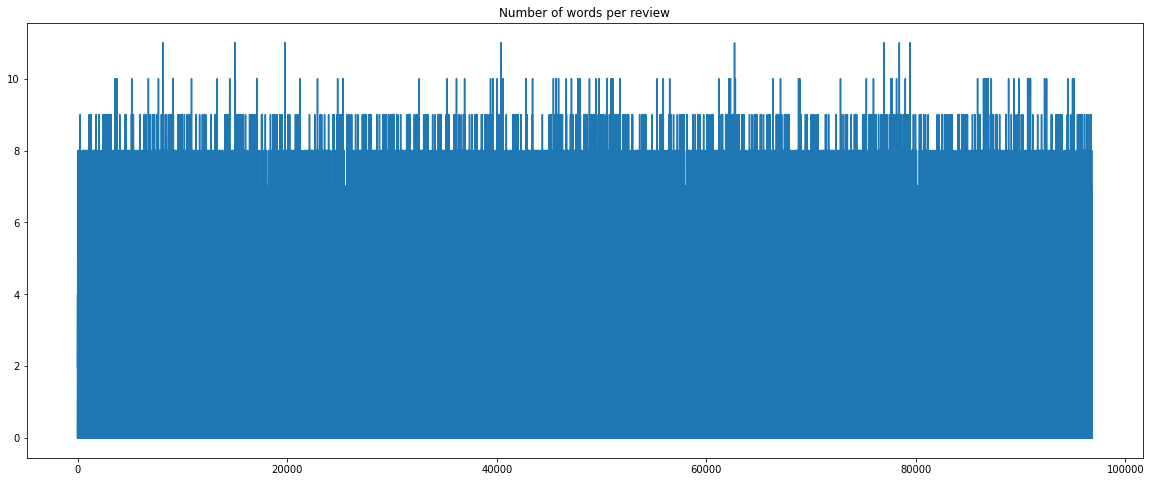

In [ ]:
cleaned["review_size"].plot(title="Number of words per review", figsize=(20, 8))

In [ ]:
del cleaned["review_size"]
cleaned.describe()

,y
count,96805.000000
mean,3.934673
std,0.542127
min,1.000000
25%,4.000000
50%,4.000000
75%,4.000000
max,5.000000


In [ ]:
scores = cleaned.groupby(["y"]).agg("count")

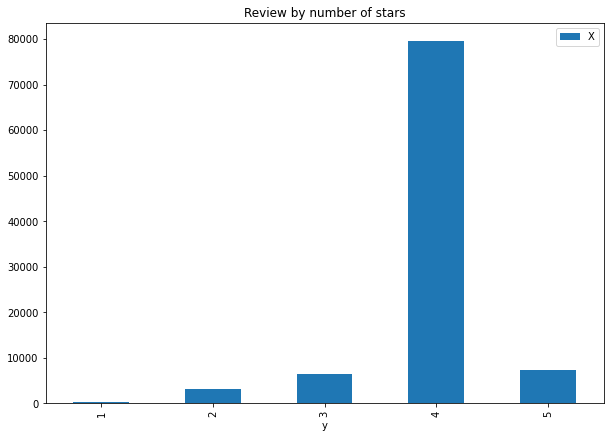

In [ ]:
scores.plot(kind='bar', title="Review by number of stars", figsize=(10, 7))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [ ]:
# Lets tokenize the works, we will only keep the 20.000 most common words
VOCAB_SIZE=20000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(cleaned["X"])
sequences = tokenizer.texts_to_sequences(cleaned["X"])
print("Number of sequences", len(sequences))

Number of sequences 96805


In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print("Index for 'great' is ", word_index["great"])

Found 17925 unique tokens.
Index for 'great' is  3


In [ ]:
SEQUENCE_SIZE=120
data = pad_sequences(sequences, maxlen=SEQUENCE_SIZE)
print("Our padded data has a shape of ", data.shape)

Our padded data has a shape of  (96805, 120)


In [ ]:
labels = cleaned["y"]
# Normalize the labels to values between 0 and 1, this can be done by simply dividing by 5, we will later need to multiply our predictions by 5
labels = labels / 5

In [ ]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (96805, 120)
Shape of label tensor: (96805,)


In [ ]:
validation_split = int(data.shape[0] * 0.7)
X_train = data[0: validation_split]
y_train = labels[0: validation_split]

X_test = data[validation_split:]
y_test = labels[validation_split:]

In [ ]:
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test", X_test.shape, "y_test", y_test.shape)

X_train (67763, 120) y_train (67763,)
X_test (29042, 120) y_test (29042,)


LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, TimeDistributed, Embedding, Dropout
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=SEQUENCE_SIZE))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear"))

In [ ]:
from keras.optimizers import RMSprop

rmsprop = RMSprop(lr=0.0001)

model.compile(loss='mae', optimizer=rmsprop)
for layer in model.layers:
    print("Layer", layer.name, "Is trainable? ==>", layer.trainable)
model.summary()

Layer embedding_1 Is trainable? ==> True
Layer dropout_1 Is trainable? ==> True
Layer lstm_1 Is trainable? ==> True
Layer dropout_2 Is trainable? ==> True
Layer dense_1 Is trainable? ==> True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,365,825
Trainable params: 2,365,825
Non-trai

In [ ]:
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 47434 samples, validate on 20329 samples
Epoch 1/8
47434/47434 [==============================] - 303s 6ms/step - loss: 0.0852 - val_loss: 0.0752
Epoch 2/8
47434/47434 [==============================] - 302s 6ms/step - loss: 0.0678 - val_loss: 0.0647
Epoch 3/8
47434/47434 [==============================] - 301s 6ms/step - loss: 0.0651 - val_loss: 0.0649
Epoch 4/8
47434/47434 [==============================] - 300s 6ms/step - loss: 0.0634 - val_loss: 0.0738
Epoch 5/8
47434/47434 [==============================] - 304s 6ms/step - loss: 0.0620 - val_loss: 0.0632
Epoch 6/8
47434/47434 [==============================] - 307s 6ms/step - loss: 0.0611 - val_loss: 0.0641
Epoch 7/8
47434/47434 [==============================] - 316s 7ms/step - loss: 0.0605 - val_loss: 0.0782
Epoch 8/8
47434/47434 [==============================] - 322s 7ms/step - loss: 0.0599 - val_loss: 0.0633


In [ ]:
model_history = pd.DataFrame.from_dict(history.history)
model_history

,val_loss,loss
0,0.075175,0.085192
1,0.064686,0.067799
2,0.064881,0.065083
3,0.073804,0.063384
4,0.063233,0.061977
5,0.064099,0.061104
6,0.078195,0.060514
7,0.063334,0.059865


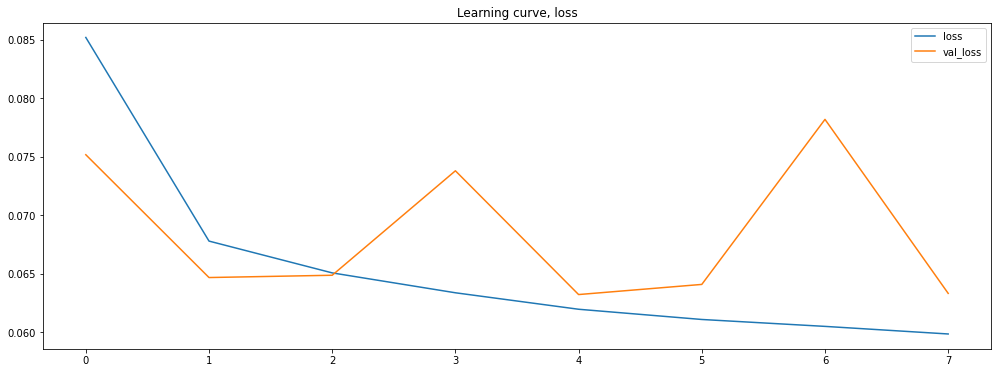

In [ ]:
model_history[["loss", "val_loss"]].plot(title="Learning curve, loss", figsize=(17, 6))

In [ ]:
results = model.evaluate(X_test, y_test)

print(results)

29042/29042 [==============================] - 16s 565us/step
0.04137009042787548


In [ ]:
five_star_review = """True five star dinner"""
three_star_review = """Arrogant and bad service, Slow Service, Cold Food"""
one_star_review = """Poor quality, small portions, miserable, Awful Service"""

texts = [five_star_review, three_star_review, one_star_review]

text_data = pd.DataFrame(data=texts, columns=["Reviews"])
text_data["Reviews"] = text_data.apply(clean_text, axis=1)
sequences_test = tokenizer.texts_to_sequences(text_data["Reviews"])
to_predict = pad_sequences(sequences_test, maxlen=SEQUENCE_SIZE)

output = model.predict(to_predict, verbose=False)
print("Predicted", output*5)

Predicted [[4.012465 ]
 [3.9299836]
 [3.9358373]]


In [ ]:
embeddings_index = {}
with open('/content/glove.6B.100d.txt', 'r') as f:
    # data = f.read()
  count = 0
  for line in f:
      count += 1
      if count % 100000 == 0:
          print(count, "vectors so far...")
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  print('Found %s word vectors.' % len(embeddings_index))

100000 vectors so far...
200000 vectors so far...
300000 vectors so far...
400000 vectors so far...
Found 400000 word vectors.


In [ ]:
print("Word 'great' has a vector like this \n", embeddings_index["great"])

Word 'great' has a vector like this 
 [-0.013786   0.38216    0.53236    0.15261   -0.29694   -0.20558
 -0.41846   -0.58437   -0.77355   -0.87866   -0.37858   -0.18516
 -0.128     -0.20584   -0.22925   -0.42599    0.3725     0.26077
 -1.0702     0.62916   -0.091469   0.70348   -0.4973    -0.77691
  0.66045    0.09465   -0.44893    0.018917   0.33146   -0.35022
 -0.35789    0.030313   0.22253   -0.23236   -0.19719   -0.0053125
 -0.25848    0.58081   -0.10705   -0.17845   -0.16206    0.087086
  0.63029   -0.76649    0.51619    0.14073    1.019     -0.43136
  0.46138   -0.43585   -0.47568    0.19226    0.36065    0.78987
  0.088945  -2.7814    -0.15366    0.01015    1.1798     0.15168
 -0.050112   1.2626    -0.77527    0.36031    0.95761   -0.11385
  0.28035   -0.02591    0.31246   -0.15424    0.3778    -0.13599
  0.2946    -0.31579    0.42943    0.086969   0.019169  -0.27242
 -0.31696    0.37327    0.61997    0.13889    0.17188    0.30363
 -1.2776     0.044423  -0.52736   -0.88536   -0.1

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print("Size of the embedding matrix is ", embedding_matrix.shape)

Size of the embedding matrix is  (17926, 100)


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,  # Input dim
                            EMBEDDING_DIM,  # Output dim
                            weights=[embedding_matrix],
                            input_length=SEQUENCE_SIZE,  
                            trainable=False)

# This layer will take an input of 
#           BatchSize x SEQUENCE_SIZE
# And the output will be
#           None, SEQUENCE_LENGTH, 100

In [ ]:
from keras.layers import Flatten, TimeDistributed
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add((Dense(1, activation='linear')))

In [ ]:
rmsprop = RMSprop(lr=0.001)

model.compile(loss='mae', optimizer=rmsprop)

for layer in model.layers:
    print("Layer", layer.name, "Is trainable? ==>", layer.trainable)
model.summary()

Layer embedding_3 Is trainable? ==> False
Layer dropout_3 Is trainable? ==> True
Layer lstm_2 Is trainable? ==> True
Layer dropout_4 Is trainable? ==> True
Layer dense_2 Is trainable? ==> True
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 100)          1792600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,909,977
Trainable params: 117,377
Non-train

In [ ]:
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.3)

Train on 47434 samples, validate on 20329 samples
Epoch 1/8
47434/47434 [==============================] - 291s 6ms/step - loss: 0.0743 - val_loss: 0.0783
Epoch 2/8
47434/47434 [==============================] - 293s 6ms/step - loss: 0.0649 - val_loss: 0.0731
Epoch 3/8
47434/47434 [==============================] - 296s 6ms/step - loss: 0.0577 - val_loss: 0.0659
Epoch 4/8
47434/47434 [==============================] - 292s 6ms/step - loss: 0.0514 - val_loss: 0.0677
Epoch 5/8
47434/47434 [==============================] - 289s 6ms/step - loss: 0.0462 - val_loss: 0.0677
Epoch 6/8
47434/47434 [==============================] - 297s 6ms/step - loss: 0.0418 - val_loss: 0.0603
Epoch 7/8
47434/47434 [==============================] - 300s 6ms/step - loss: 0.0402 - val_loss: 0.0609
Epoch 8/8
47434/47434 [==============================] - 300s 6ms/step - loss: 0.0402 - val_loss: 0.0603


In [ ]:
model_history = pd.DataFrame.from_dict(history.history)
model_history

,val_loss,loss
0,0.078305,0.074300
1,0.073052,0.064879
2,0.065910,0.057651
3,0.067723,0.051427
4,0.067689,0.046238
5,0.060279,0.041801
6,0.060850,0.040249
7,0.060345,0.040199


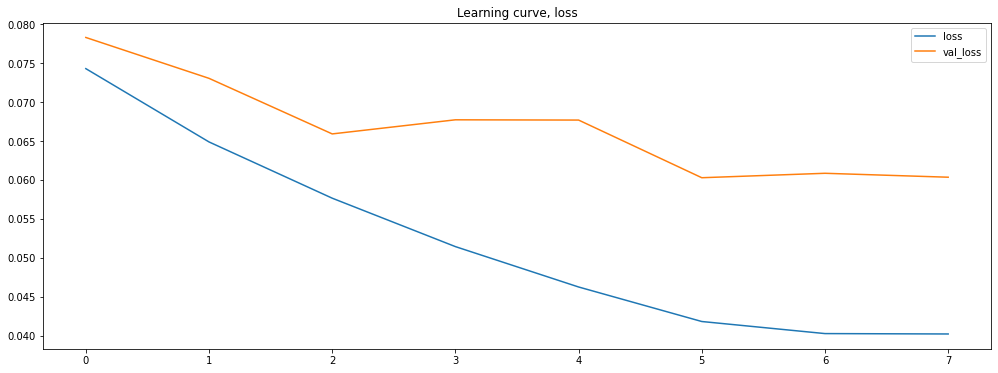

In [ ]:
model_history[["loss", "val_loss"]][model_history["loss"]< 3].plot(title="Learning curve, loss", figsize=(17, 6))

In [ ]:
output = model.predict(to_predict, verbose=False)
print("Predicted", output*5)

Predicted [[3.9974165]
 [3.9958153]
 [3.991908 ]]


In [ ]:
model.evaluate(X_test, y_test)

29042/29042 [==============================] - 16s 546us/step


0.0379214518474618

With Labelling the Reviews

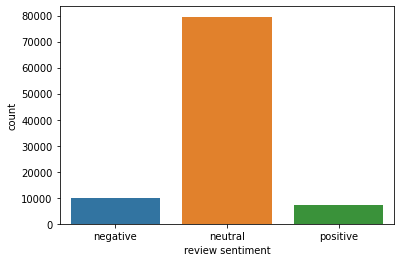

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def to_sentiment(rating):
  rating = int(rating)
  if rating <= 3:
    return 0
  elif rating == 4:
    return 1
  else:
    return 2
raw['sentiment'] = raw.Rating.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

plt.xlabel('review score');
ax = sns.countplot(raw.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
cleaned.head()

,X,y,sentiment
0,just like home,5,2
1,great food and staff,4,1
2,satisfaction,4,1
3,true five star dinner,5,2
4,best meal ever,4,1


In [ ]:
rmsprop = RMSprop(lr=0.001)

model.compile(loss='mae', optimizer=rmsprop, metrics=['accuracy'])

for layer in model.layers:
    print("Layer", layer.name, "Is trainable? ==>", layer.trainable)
model.summary()

Layer embedding_3 Is trainable? ==> False
Layer dropout_3 Is trainable? ==> True
Layer lstm_2 Is trainable? ==> True
Layer dropout_4 Is trainable? ==> True
Layer dense_2 Is trainable? ==> True
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 100)          1792600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,909,977
Trainable params: 117,377
Non-train